# Introduction to Spatial Omics with 10X Xenium and Visium
...

## The breast cancer dataset

## Setup

In [1]:
!wget https://www.huber.embl.de/users/harald/embo/xenium_rep1.h5ad
!wget https://www.huber.embl.de/users/harald/embo/BC_atlas_xe.h5ad

--2024-02-20 13:43:49--  https://www.huber.embl.de/users/harald/embo/xenium_rep1.h5ad
Resolving www.huber.embl.de (www.huber.embl.de)... 194.94.44.40
Connecting to www.huber.embl.de (www.huber.embl.de)|194.94.44.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108640284 (104M) [application/octet-stream]
Saving to: ‘xenium_rep1.h5ad.3’

xenium_rep1.h5ad.3  100%[===================>] 103.61M  15.5MB/s    in 7.1s    

2024-02-20 13:43:56 (14.6 MB/s) - ‘xenium_rep1.h5ad.3’ saved [108640284/108640284]

--2024-02-20 13:43:56--  https://www.huber.embl.de/users/harald/embo/BC_atlas_xe.h5ad
Resolving www.huber.embl.de (www.huber.embl.de)... 194.94.44.40
Connecting to www.huber.embl.de (www.huber.embl.de)|194.94.44.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6298520 (6.0M) [application/octet-stream]
Saving to: ‘BC_atlas_xe.h5ad.3’

BC_atlas_xe.h5ad.3  100%[===================>]   6.01M  5.98MB/s    in 1.0s    

2024-02-20 13:43:58 (5.9

In [ ]:
!pip install scanpy
!pip install squidpy
!pip install leidenalg

In [ ]:
import pandas as pd
import xlrd
from pathlib import Path
import json
from collections import namedtuple, Counter

import numpy as np
import scanpy as sc
import squidpy as sq
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import KDTree

from matplotlib import rcParams
FIGSIZE=(10,10)
rcParams['figure.figsize']=FIGSIZE

# sc.settings.verbosity = 0
# sc._settings.ScanpyConfig.verbosity = 0

# import warnings
# warnings.filterwarnings("ignore")

In [9]:
xe_rep1 = sc.read('xenium_rep1.h5ad')
xe_atlas = sc.read('BC_atlas_xe.h5ad')

In [5]:
xe_rep1

AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'Cluster', 'replicate'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'Cluster_colors'
    obsm: 'spatial'

In [7]:
sq.pl.spatial_scatter(
    xe_rep1,
    library_id="spatial",
    shape=None,
    color=[
        "Cluster",
    ],
    wspace=0.4,
)

AttributeError: 'int' object has no attribute 'level'

## Preprocessing

### Quality control and Filtering




In [7]:
sc.pp.calculate_qc_metrics(xe_rep1, percent_top=(10, 20, 50, 150), inplace=True)

In [8]:
cprobes = (
    xe_rep1.obs["control_probe_counts"].sum() / xe_rep1.obs["total_counts"].sum() * 100
)
cwords = (
    xe_rep1.obs["control_codeword_counts"].sum() / xe_rep1.obs["total_counts"].sum() * 100
)

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

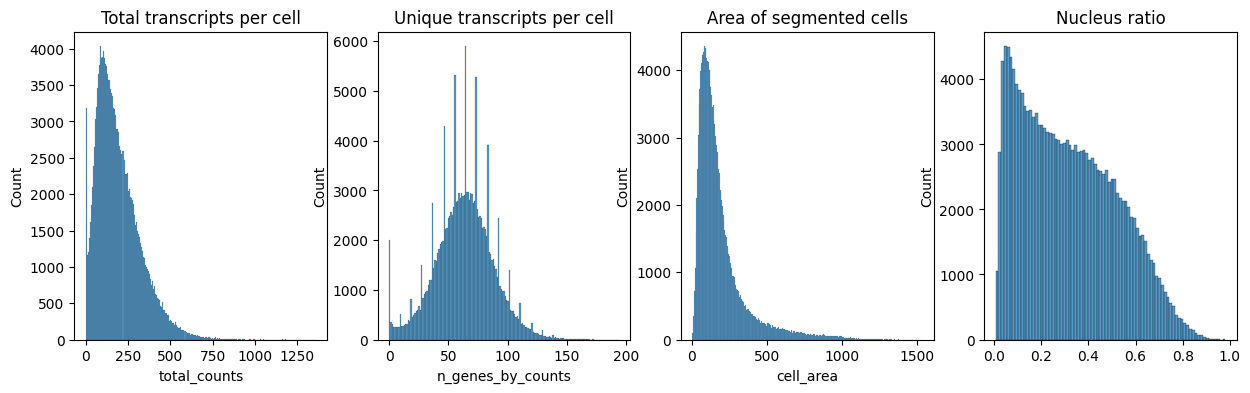

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    xe_rep1.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    xe_rep1.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    xe_rep1.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    xe_rep1.obs["nucleus_area"] / xe_rep1.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

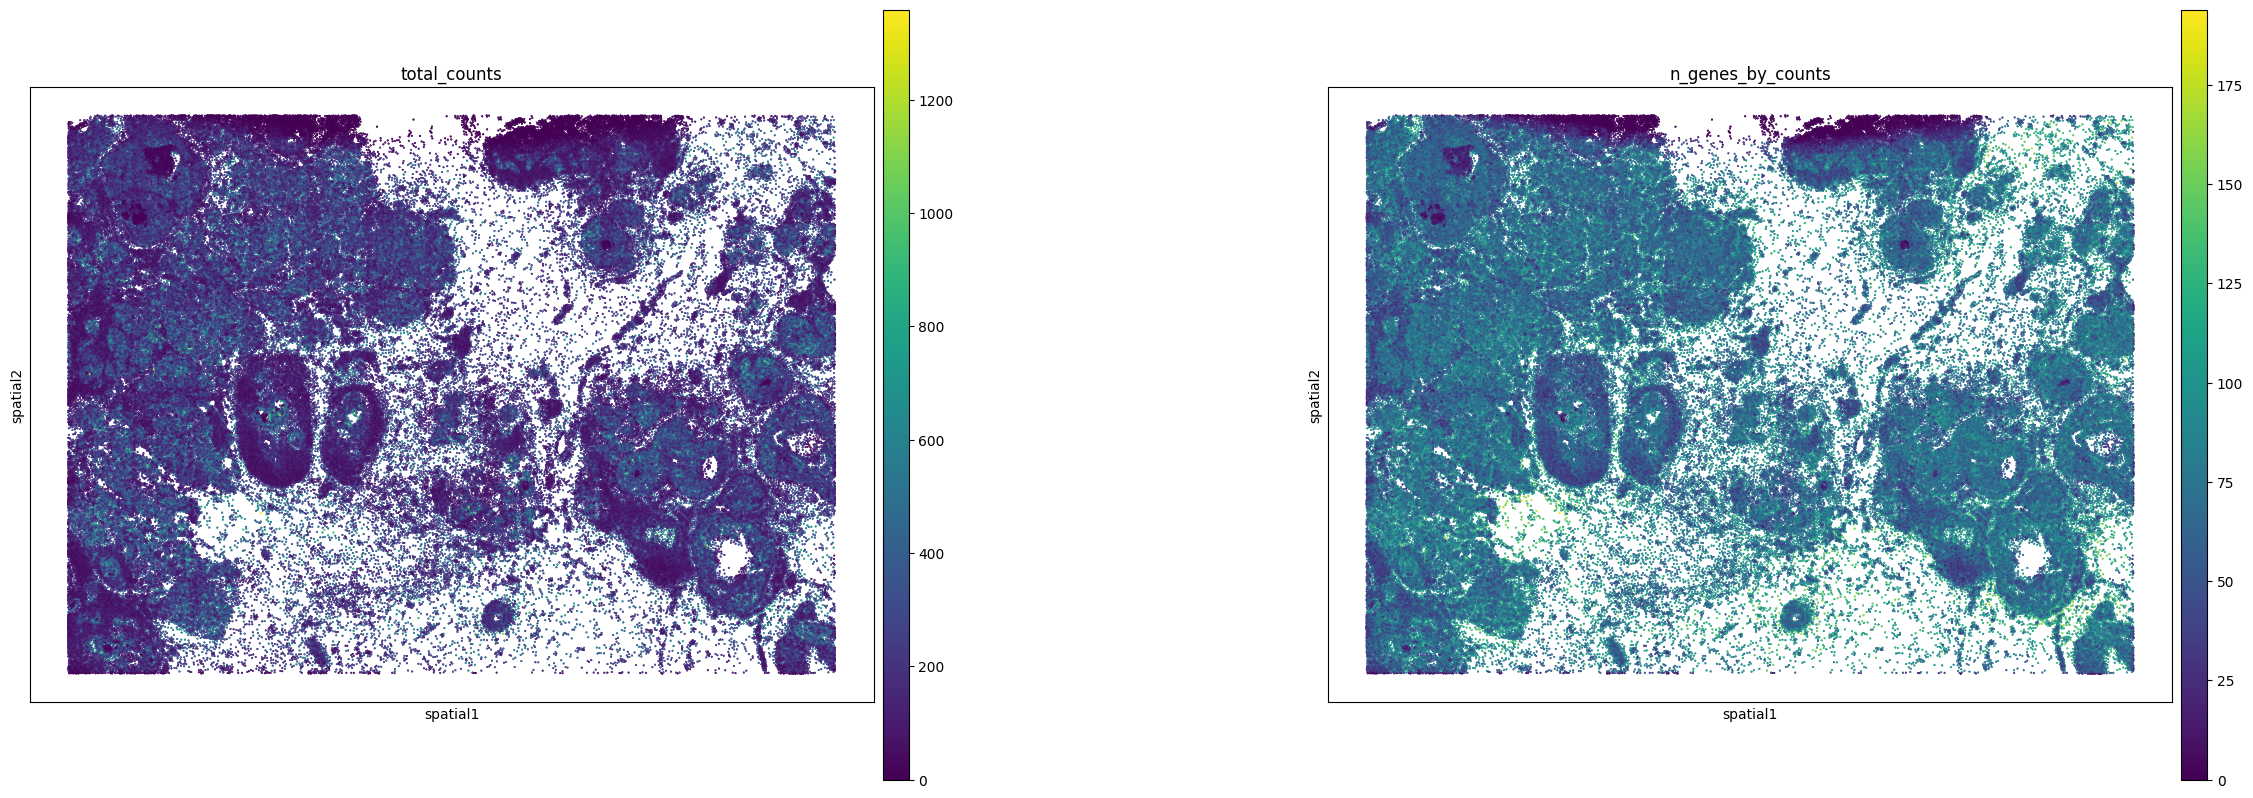

In [12]:
sq.pl.spatial_scatter(
    xe_rep1,
    library_id="spatial",
    shape=None,
    color=[
        "total_counts",
        "n_genes_by_counts"
    ],
    wspace=0.4,
)

In [13]:
sc.pp.filter_cells(xe_rep1, min_counts=50)
sc.pp.filter_genes(xe_rep1, min_cells=5)

### Normalization and dimention reduction

In [14]:
xe_rep1.layers["counts"] = xe_rep1.X.copy()
sc.pp.normalize_total(xe_rep1, inplace=True)
sc.pp.log1p(xe_rep1)
sc.pp.pca(xe_rep1)
sc.pp.neighbors(xe_rep1)
sc.tl.umap(xe_rep1)
sc.tl.leiden(xe_rep1)

## Cell type annotation

In [15]:
sc.pp.neighbors(xe_atlas)
sc.tl.pca(xe_atlas)
sc.tl.umap(xe_atlas)
xe_rep1 = xe_rep1[:, xe_atlas.var_names]
sc.tl.ingest(xe_rep1, xe_atlas, obs='celltype_major')

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_ingest.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [cat_array[inds].mode()[0] for inds in self._indices]
/usr/lib/python3.10/_collections_abc.py:999: ImplicitModificationWarning: Setting element `.obsm['rep']` of view, initializing view as actual.
  self[key] = other[key]
/usr/lib/python3.10/_collectio

/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:956: UserWarnin

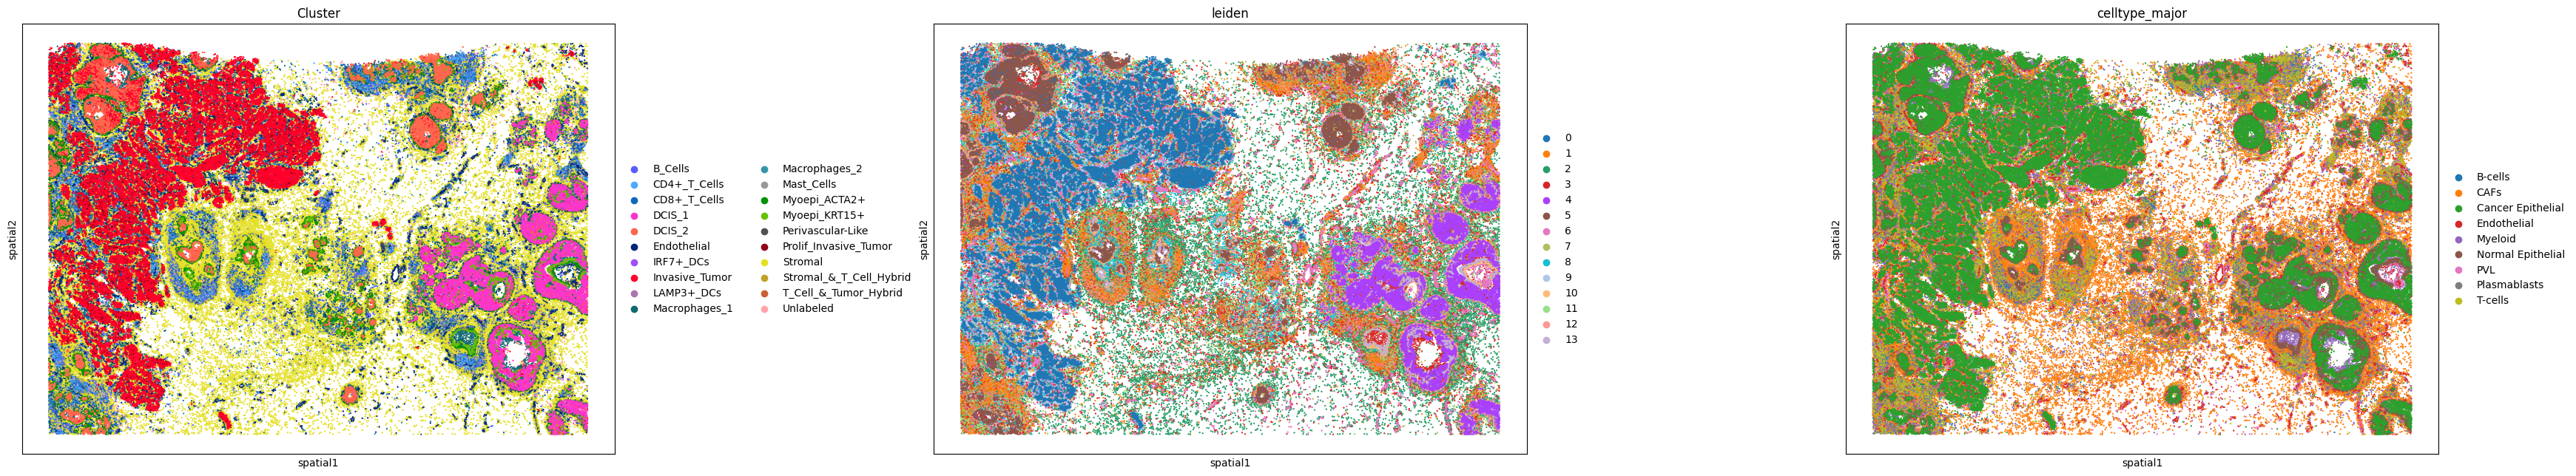

In [16]:
sq.pl.spatial_scatter(
    xe_rep1,
    library_id="spatial",
    shape=None,
    color=[
        "Cluster",
        "leiden",
        "celltype_major"
    ],
    wspace=0.4,
)

<Axes: xlabel='celltype_major', ylabel='Cluster'>

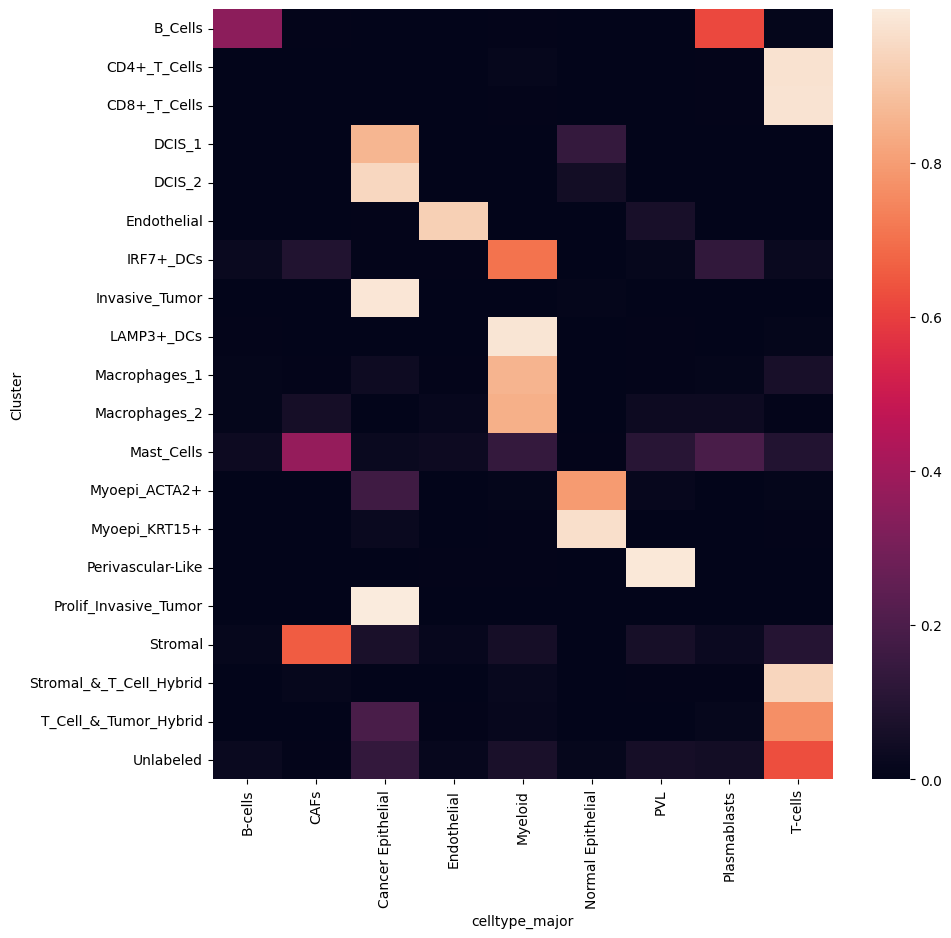

In [17]:
cmtx = sc.metrics.confusion_matrix("Cluster", "celltype_major", xe_rep1.obs)
sns.heatmap(cmtx)

In [22]:
sc._settings.ScanpyConfig.verbosity = 0

In [24]:
sc.tl.rank_genes_groups(xe_rep1, 'leiden', method='logreg',max_iter=100)
sc.pl.rank_genes_groups_dotplot(xe_rep1, n_genes=4, standard_scale='var')
sc.tl.rank_genes_groups(xe_rep1, 'Cluster', method='logreg',max_iter=100)
sc.pl.rank_genes_groups_dotplot(xe_rep1, n_genes=4, standard_scale='var')
sc.tl.rank_genes_groups(xe_rep1, 'celltype_major', method='logreg',max_iter=100)
sc.pl.rank_genes_groups_dotplot(xe_rep1, n_genes=4, standard_scale='var')

AttributeError: 'int' object has no attribute 'level'

## Spatial patterns

### Neighborhood graphs

In [25]:
sq.gr.spatial_neighbors(xe_rep1, coord_type="generic", n_neighs=15)

AttributeError: 'int' object has no attribute 'level'

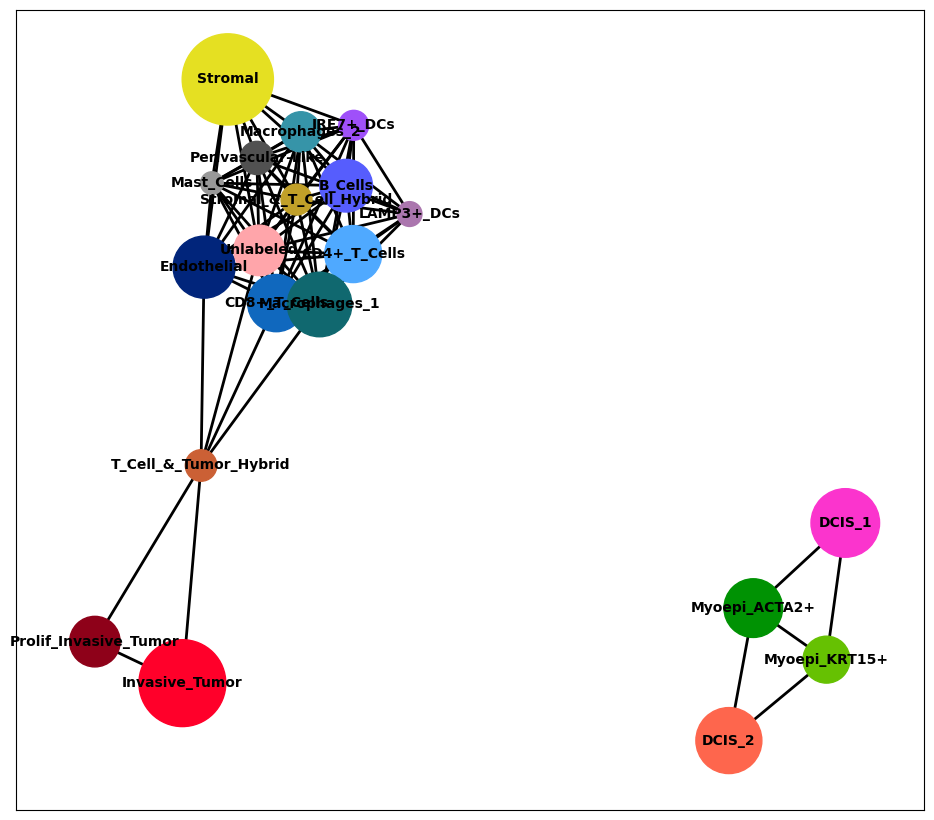

In [20]:
sc.tl.paga(xe_rep1, groups='Cluster', neighbors_key="spatial_neighbors", copy=False)
sc.pl.paga(xe_rep1, max_edge_width=2, node_size_scale=10, threshold= 1)

### Celltype colocalization

In [21]:
# sq.gr.nhood_enrichment(xe_rep1, cluster_key="Cluster")
sq.pl.nhood_enrichment(
    xe_rep1,
    cluster_key="Cluster",
    method="average",
    cmap="inferno",
    vmin=-50,
    vmax=100,
    figsize=(5, 5),
    title='celltype colocalization'
)

KeyError: "Unable to get the data from `adata.uns['Cluster_nhood_enrichment']`. Please run `squidpy.gr.nhood_enrichment(..., cluster_key='Cluster')` first."

### Spatially informative genes

In [ ]:
# sq.gr.spatial_autocorr(xe_rep1, mode="moran")
top_genes = xe_rep1.uns["moranI"].head().index
low_genes = xe_rep1.uns["moranI"].tail().index
sq.pl.spatial_scatter(
    xe_rep1, shape=None, color=top_genes.append(low_genes), size=3, ncols=5, legend_loc=None,
)

## Niche detection

In [ ]:
from sklearn.neighbors import KDTree
import numpy as np
from scipy.sparse import lil_matrix

def knn_adjacency_matrix(data_matrix, k):
    # Construct a KDTree from the data matrix
    tree = KDTree(data_matrix)

    # Query the KDTree to find k nearest neighbors for each point
    distances, indices = tree.query(data_matrix, k+1)  # k+1 because the nearest neighbor is the point itself

    # Initialize a sparse matrix to hold the adjacency matrix
    n = len(data_matrix)
    adjacency_matrix = lil_matrix((n, n), dtype=int)

    # Populate the adjacency matrix
    for i in range(n):
        for j in indices[i, 1:]:  # Exclude the first neighbor (itself)
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1  # Assuming undirected graph

    return adjacency_matrix

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
celltype_one = ohe.fit_transform(xe_rep1.obs[['Cluster']])
celltype_dist = xe_rep1.obsp['spatial_connectivities'] @ celltype_one
celltype_dist /= celltype_dist.sum(axis=1)
xe_rep1.obsm['celltype_dist'] = celltype_dist
sc.pp.subsample(xe_rep1, 0.1)
a = knn_adjacency_matrix(xe_rep1.obsm['celltype_dist'].toarray(), k = 50)
xe_rep1.obsp['niche_connectivities_minor'] = a.toarray()
sc.tl.leiden(xe_rep1, adjacency=xe_rep1.obsp['niche_connectivities_minor'], key_added='niche', resolution=0.01)

In [ ]:
sq.pl.spatial_scatter(
    xe_rep1,
    library_id="spatial",
    shape=None,
    color=[
        "niche",
        "Cluster"
    ],
    wspace=0.4,
)

## Extra links

* `SpatialData`, a framework for wrangling one and multiple spatial omics datasets across samples and technologies: [link](https://spatialdata.scverse.org/en/latest/)
* Linear alignment of Xenium and Visium (10X general): [link](https://www.10xgenomics.com/support/software/xenium-explorer/latest/tutorials/xe-image-alignment)
* None-linear alignment of Xenium and Visium (STalign): [link](https://jef.works/blog/2023/12/27/alignment-of-spatial-transcriptomics-data-using-STalign/)
* Xenium Cell Segmentation: [link](https://www.biorxiv.org/content/10.1101/2023.02.13.528102v1)